# Observation-Level Models
Supplementary analyses in which we look at the group advantage for *each unit of collaboration, on a given task x complexity x group size*.

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import pprint
import statsmodels.api as sm
from patsy import dmatrix, dmatrices, build_design_matrices
from scipy.linalg import qr, svd, solve_triangular
from statsmodels.stats import multitest
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.compose import ColumnTransformer
from typing import Dict, Any, List, Optional
import time
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy import stats
from scipy.stats import levene, norm
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
from matplotlib.colors import to_rgb
import colorsys
import itertools

plt.rcParams['figure.dpi'] = 900
colors = plt.colormaps["Dark2"].colors
from tqdm import tqdm

# silence warnings because the NN has a lot of them
import warnings
warnings.filterwarnings("ignore")
import random

# for saving model params
import pickle

# for feature importance
import shap
from sklearn.metrics import mean_squared_error
import copy
import ast

In [2]:
from pathlib import Path
from functools import lru_cache

@lru_cache(maxsize=1)
def get_project_root():
    notebook_dir = Path().resolve()
    for candidate in [notebook_dir, *notebook_dir.parents]:
        if (candidate / "outputs").exists() and (candidate / "analysis").exists():
            return candidate
    return notebook_dir

PROJECT_ROOT = get_project_root()
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
PROCESSED_DATA_DIR = OUTPUTS_DIR / "processed_data"
CACHED_PKLS_DIR = OUTPUTS_DIR / "cached_pkls"

for path in [PROCESSED_DATA_DIR, CACHED_PKLS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

In [3]:
# OBSERVATIONAL-LEVEL DATA
df_observation_level_data = pd.read_csv(
    PROCESSED_DATA_DIR / "observation_level_dv_with_composition.csv"
).drop(columns=["features", "synergy"])

# rounds and stages metadata
df_rounds = pd.read_csv(PROCESSED_DATA_DIR / "rounds.csv")
df_stages = pd.read_csv(PROCESSED_DATA_DIR / "stages.csv")

# condition-level with mcgrath categories
df_condition_data_with_mcgrath_types = pd.read_csv(
    PROCESSED_DATA_DIR / "condition_level_group_advantage_with_ivs_and_categories.csv"
)

In [4]:
def add_task_ordering_column(df):
    # Get ordering per gameId
    orderings = (
        df.sort_values(['gameId', 'data.anonName'])
          .groupby('gameId')['data.type']
          .apply(list)
          .reset_index(name='ordering')
    )
    
    # Convert list to tuple for immutability
    orderings['ordering'] = orderings['ordering'].apply(tuple)
    
    # Merge back into the original dataframe
    df_with_ordering = df.merge(orderings, on='gameId', how='left')
    
    return df_with_ordering

df_rounds = add_task_ordering_column(df_rounds)

In [5]:
df_rounds_orderings = df_rounds[['roundId', 'stageIds', 'index', 'gameId', 'ordering']].rename(columns={'index': 'round_index', 'stageIds': 'stageIds_in_round'})

In [6]:
# split df_rounds_orderings by stageIds_in_round and create a new row for each stageId
def split_by_stage_ids(df):
    # Explode the stageIds_in_round column into multiple rows
    df['stageIds_in_round'] = df['stageIds_in_round'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
    df_exploded = df.explode('stageIds_in_round')
    
    # Reset index to clean up after explode
    df_exploded.reset_index(drop=True, inplace=True)
    # Rename stageIds_in_round to stageId for clarity
    df_exploded.rename(columns={'stageIds_in_round': 'stageId'}, inplace=True)

    # Store the indices of the stageIds that were split, so we know the order
    df_exploded['stage_index'] = df_exploded.groupby('roundId').cumcount() - 2 # zero-indexed, plus -1 to account for practice stage
    
    return df_exploded

if('stageIds_in_round' in df_rounds_orderings.columns):
    df_rounds_orderings = split_by_stage_ids(df_rounds_orderings)

In [7]:
df_stages = pd.read_csv(PROCESSED_DATA_DIR / "stages.csv")
df_rounds_orderings = df_rounds_orderings.merge(df_stages[["stageId", "displayName"]], on='stageId', how='left')

# filter out practice stages (stage_index < 0)
df_rounds_orderings = df_rounds_orderings[df_rounds_orderings['stage_index'] >= 0]

Merge the round orderings into the observation-level data

In [8]:
df_observation_level_data = df_rounds_orderings.merge(df_observation_level_data, on='stageId', how='right')

In [9]:
# add in categorical task types
df_condition_data_with_mcgrath_types = pd.read_csv(
    PROCESSED_DATA_DIR / "condition_level_group_advantage_with_ivs_and_categories.csv"
)
mcgrath_cols = df_condition_data_with_mcgrath_types.filter(like="Type").columns
# rename the mcgrath columns to have the suffic "_categorical"
df_condition_data_with_mcgrath_types = df_condition_data_with_mcgrath_types.rename(columns={col: f"{col}_categorical" for col in mcgrath_cols})
mcgrath_cols = [f"{col}_categorical" for col in mcgrath_cols]
df_observation_level_data_with_mcgrath_types = df_observation_level_data.merge(
    df_condition_data_with_mcgrath_types[["task"] + list(mcgrath_cols)].drop_duplicates(),
    on='task',
    how='left',
)

In [10]:
# also create variants of categorical columns that are not one-hot encoded

def add_complexity_column(df):
    complexity_map = {
        "Low": "Low",
        "Medium": "Medium",
        "High": "High"
    }
    # argmax across the dummy columns
    cols = [c for c in ["Low", "Medium", "High"] if c in df.columns]
    df = df.copy()
    df["complexity"] = df[cols].idxmax(axis=1).map(complexity_map)
    return df

def add_mcgrath_type_column(df):
    cat_cols = [c for c in df.columns if "_categorical" in c]
    df = df.copy()
    # get the name of the column that is 1 for each row
    df["McGrath_Type"] = df[cat_cols].idxmax(axis=1).str.replace("_categorical", "")
    return df

df_observation_level_data_with_mcgrath_types = add_complexity_column(df_observation_level_data_with_mcgrath_types)
df_observation_level_data_with_mcgrath_types = add_mcgrath_type_column(df_observation_level_data_with_mcgrath_types)

variables for demographics

In [11]:
FOCAL_DEMOGRAPHIC_COLS = ['IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS',
						'RME', 'CRT', 'birth_year', 'education_level', 'income_max', 'political_fiscal', 'political_party', 'political_social',
						'gender', 'race', 'marital_status']
ALL_DEMOGRAPHIC_COLS = FOCAL_DEMOGRAPHIC_COLS + ['IRCS_IS', 'income_min']

COMPOSITION_IVS = [col for col in df_observation_level_data.columns if any(col.startswith(prefix) for prefix in FOCAL_DEMOGRAPHIC_COLS)]

# Viz (Descriptive, Observational-Level)

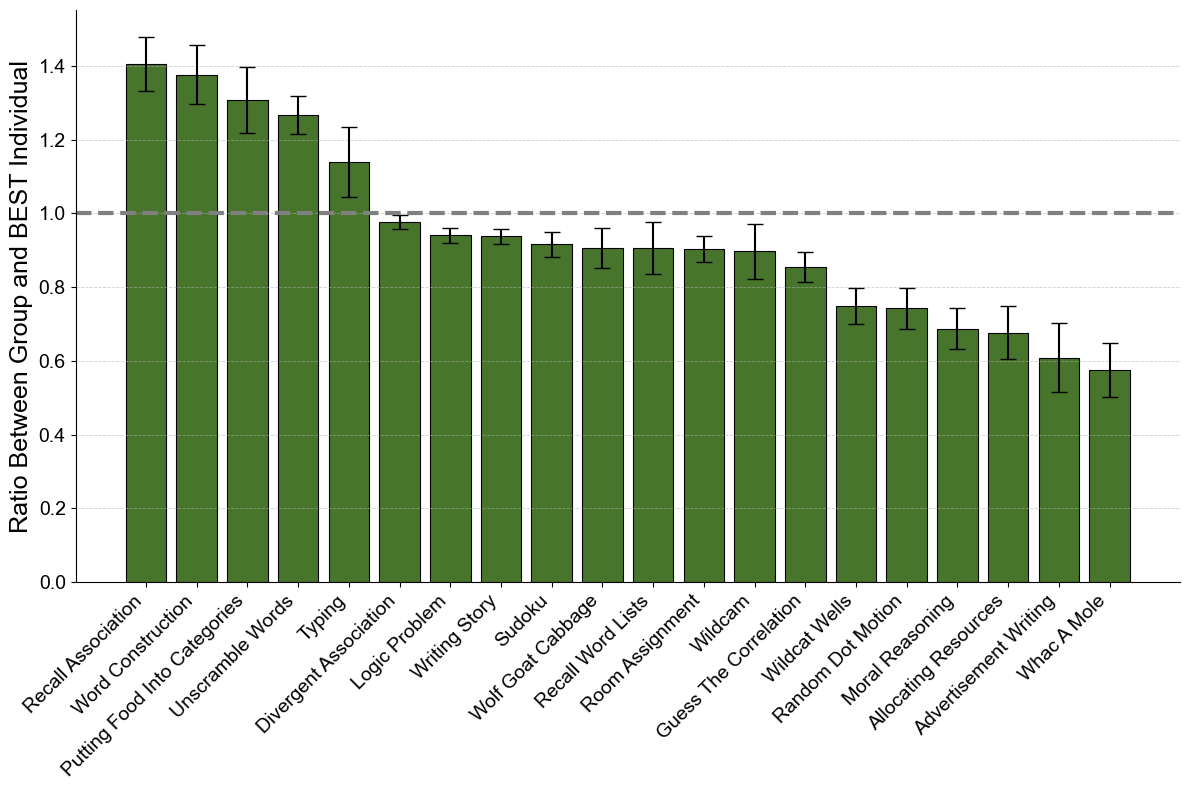

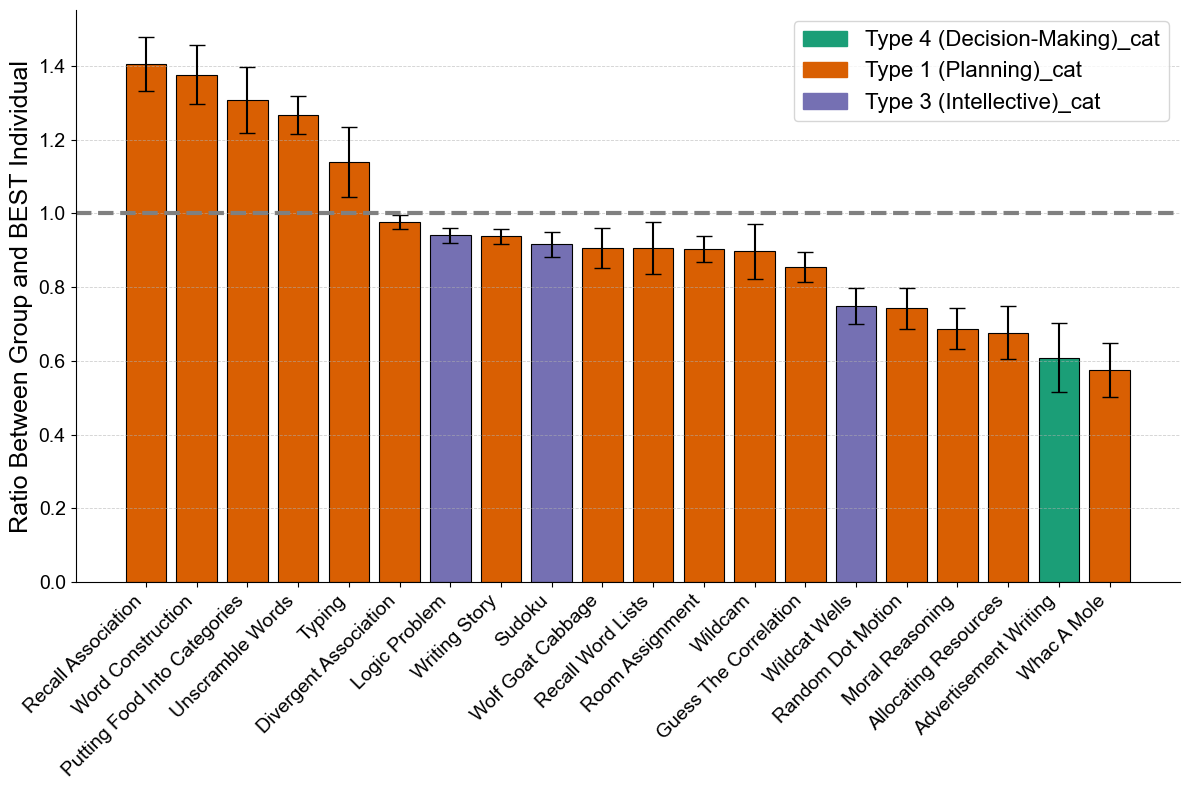

ValueError: No McGrath type found matching 'generate'

In [12]:
def plot_task_bars(
    df: pd.DataFrame,
    y_col: str = None,
    color_by_mcgrath: bool = False,
    highlight_type: Optional[str] = None,
):
    if y_col is None:
        candidates = [c for c in df.select_dtypes(include=[np.number]).columns if c != "task"]
        if not candidates:
            raise ValueError("No numeric columns found to plot.")
        y_col = candidates[0]

    d = df[["task", y_col]].dropna()

    def _ci_halfwidth(x):
        n = x.count()
        if n < 2:
            return 0.0
        sem = x.std(ddof=1) / np.sqrt(n)
        tcrit = stats.t.ppf(0.975, df=n-1)
        return tcrit * sem

    g = d.groupby("task", dropna=False)[y_col]
    summary = pd.DataFrame({
        "mean": g.mean(),
        "n": g.count(),
        "ci_half": g.apply(_ci_halfwidth)
    }).reset_index()

    # Handle McGrath coloring
    if color_by_mcgrath and "McGrath_Type" in df.columns:
        mcgrath_map = df.groupby("task")["McGrath_Type"].first()
        summary = summary.merge(mcgrath_map, on="task", how="left")

        # assign "default" colors first
        unique_types = summary["McGrath_Type"].unique()
        base_colors = list(plt.cm.Dark2.colors)
        color_cycle = itertools.cycle(base_colors)
        default_lookup = {t: next(color_cycle) for t in unique_types}

        if highlight_type is not None:
            highlight_type = str(highlight_type).lower()
            match = next(
                (t for t in unique_types if highlight_type in t.lower()),
                None
            )
            if match is None:
                raise ValueError(f"No McGrath type found matching '{highlight_type}'")

            # keep the original Dark2 color for the highlight type
            highlight_color = default_lookup[match]
            summary["color"] = summary["McGrath_Type"].apply(
                lambda t: highlight_color if t == match else "lightgray"
            )

            # no legend when highlighting
            color_lookup = {match: highlight_color, "Other": "lightgray"}
            show_legend = False
        else:
            # normal mode: keep all categories distinct
            summary["color"] = summary["McGrath_Type"].map(default_lookup)
            color_lookup = default_lookup
            show_legend = True

    else:
        summary["color"] = "#48752C"
        color_lookup = {}

    # sort by mean, descending
    summary = summary.sort_values("mean", ascending=False)

    plt.style.use("default")
    plt.rcParams.update({
        "font.family": "Arial",
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "figure.facecolor": "white",
        "axes.facecolor": "white",
    })

    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(summary))
    ax.bar(
        x, summary["mean"].values,
        yerr=summary["ci_half"].values,
        capsize=6,
        linewidth=0.8,
        edgecolor="black",
        color=summary["color"].values
    )

    ax.axhline(y=1, color="grey", linestyle="--", linewidth=3)

    if y_col == "strong":
        ylabel = "Ratio Between Group and BEST Individual"
    elif y_col == "weak":
        ylabel = "Ratio Between Group and RANDOM Individual"
    else:
        ylabel = y_col
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(summary["task"].astype(str).str.title(), rotation=45, ha="right")

    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if color_by_mcgrath and "McGrath_Type" in summary.columns:
        if highlight_type is not None:
            handles = [
                plt.Rectangle((0,0),1,1, color=color_lookup[match]),
                plt.Rectangle((0,0),1,1, color="lightgray"),
            ]
        else:
            handles = [plt.Rectangle((0,0),1,1, color=color_lookup[t]) for t in color_lookup]
            ax.legend(handles, color_lookup.keys(), loc="best", fontsize=16)

    plt.tight_layout()
    plt.show()


plot_task_bars(df_observation_level_data_with_mcgrath_types, "strong")
plot_task_bars(df_observation_level_data_with_mcgrath_types, "strong", color_by_mcgrath=True)
plot_task_bars(df_observation_level_data_with_mcgrath_types, "strong", color_by_mcgrath=True, highlight_type="Generate")
plot_task_bars(df_observation_level_data_with_mcgrath_types, "strong", color_by_mcgrath=True, highlight_type="Intellect")
plot_task_bars(df_observation_level_data_with_mcgrath_types, "strong", color_by_mcgrath=True, highlight_type="Performance")

In [ ]:
plot_task_bars(df_observation_level_data_with_mcgrath_types, "weak")

In [ ]:
df_sum_adjusted_tasks = pd.read_csv(PROCESSED_DATA_DIR / 'deduplicated_sum_synergy_df.csv')

In [ ]:
df_obs_with_sum_nonadjusted_highlighted = df_observation_level_data_with_mcgrath_types.copy()
tasks_to_replace = df_sum_adjusted_tasks['task'].unique()
for task in tasks_to_replace:
    stage_ids_for_task = df_sum_adjusted_tasks[df_sum_adjusted_tasks['task'] == task]['stageId'].unique()
    for stage_id in stage_ids_for_task:
        mask = (df_obs_with_sum_nonadjusted_highlighted['stageId'] == stage_id) & (df_obs_with_sum_nonadjusted_highlighted['task'] == task)
        df_obs_with_sum_nonadjusted_highlighted.loc[mask, "McGrath_Type"] = "Sum-Adjusted"

plot_task_bars(df_obs_with_sum_nonadjusted_highlighted, "strong", color_by_mcgrath=True, highlight_type="Sum")

df_obs_with_sum_nonadjusted_highlighted_3_player = df_obs_with_sum_nonadjusted_highlighted[df_obs_with_sum_nonadjusted_highlighted['playerCount'] == 3]
df_obs_with_sum_nonadjusted_highlighted_6_player = df_obs_with_sum_nonadjusted_highlighted[df_obs_with_sum_nonadjusted_highlighted['playerCount'] == 6]

plot_task_bars(df_obs_with_sum_nonadjusted_highlighted_3_player, "strong", color_by_mcgrath=True, highlight_type="Sum")
plot_task_bars(df_obs_with_sum_nonadjusted_highlighted_6_player, "strong", color_by_mcgrath=True, highlight_type="Sum")


In [ ]:
df_obs_level_with_sum_adjustments = df_observation_level_data_with_mcgrath_types.copy()
dv_to_replace = "strong" # compare it against the "strong" column
# for the following tasks, replace the `dv_to_replace` column with the corresponding value from "normalized_score" in df_sum_adjusted_tasks, matching with "stageId"
tasks_to_replace = df_sum_adjusted_tasks['task'].unique()

for task in tasks_to_replace:
    stage_ids_for_task = df_sum_adjusted_tasks[df_sum_adjusted_tasks['task'] == task]['stageId'].unique()
    for stage_id in stage_ids_for_task:
        mask = (df_obs_level_with_sum_adjustments['stageId'] == stage_id) & (df_obs_level_with_sum_adjustments['task'] == task)
        replacement_values = df_sum_adjusted_tasks[(df_sum_adjusted_tasks['task'] == task) & (df_sum_adjusted_tasks['stageId'] == stage_id)][['normalized_score']].values
        if len(replacement_values) > 0:
            df_obs_level_with_sum_adjustments.loc[mask, dv_to_replace] = replacement_values[0][0]
        # also replace the "McGrath Type" column to "Sum-Adjusted"
        df_obs_level_with_sum_adjustments.loc[mask, "McGrath_Type"] = "Sum-Adjusted"

# now plot it against strong synergy in all the other tasks
plot_task_bars(df_obs_level_with_sum_adjustments, "strong", color_by_mcgrath=True, highlight_type="Sum")

# split by player count
df_obs_level_with_sum_adjustments_3_player = df_obs_level_with_sum_adjustments[df_obs_level_with_sum_adjustments['playerCount'] == 3]
df_obs_level_with_sum_adjustments_6_player = df_obs_level_with_sum_adjustments[df_obs_level_with_sum_adjustments['playerCount'] == 6]  

plot_task_bars(df_obs_level_with_sum_adjustments_3_player, "strong", color_by_mcgrath=True, highlight_type="Sum")
plot_task_bars(df_obs_level_with_sum_adjustments_6_player, "strong", color_by_mcgrath=True, highlight_type="Sum")

# Run Models

### Data Structure for Storing the Final Models & Outputs

In [ ]:
base_model = {
			"OLS": {
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			},
			"E-Net": {
				"Wave 1": {"strong": None, "weak": None},
				"Wave 2": {"strong": None, "weak": None}
			}
		}

In [ ]:
try:
    # read the models and results from the previous save
    with open(CACHED_PKLS_DIR / 'models_observational.pkl', 'rb') as f:
        MODELS = pickle.load(f)
    with open(CACHED_PKLS_DIR / 'model_r2_results_observational.pkl', 'rb') as f:
        MODEL_R2_RESULTS = pickle.load(f)
    with open(CACHED_PKLS_DIR / 'model_rmse_results_observational.pkl', 'rb') as f:
        MODEL_RMSE_RESULTS = pickle.load(f)

except FileNotFoundError:
    # if the file is not found, we will create the MODELS and MODEL_R2_RESULTS dictionaries
    MODELS = {
        "Task Space": copy.deepcopy(base_model),
        "McGrath Categorical": copy.deepcopy(base_model),
        "McGrath Subspace": copy.deepcopy(base_model),
        "Group Composition": copy.deepcopy(base_model)
    }

    # create a dictionary with the same keys as MODELS to store R2 results
    MODEL_R2_RESULTS = copy.deepcopy(MODELS)

    # create a dictionary with the same keys as MODELS to store RMSE results
    MODEL_RMSE_RESULTS = copy.deepcopy(MODELS)

In [ ]:
# save MODELS and MODEL_R2_RESULTS
def save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS):
    with open(CACHED_PKLS_DIR / 'models_observational.pkl', 'wb') as f:
        pickle.dump(MODELS, f)
    with open(CACHED_PKLS_DIR / 'model_r2_results_observational.pkl', 'wb') as f:
        pickle.dump(MODEL_R2_RESULTS, f)
    with open(CACHED_PKLS_DIR / 'model_rmse_results_observational.pkl', 'wb') as f:
        pickle.dump(MODEL_RMSE_RESULTS, f)

In [ ]:
save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS)

# Linear Models 
(with random coefficients for the team and ordering controls)

In [ ]:
# Hold out 10 tasks
wave1_df_train = df_observation_level_data_with_mcgrath_types[df_observation_level_data_with_mcgrath_types["wave"] == 1] ## train on this
wave1_df_test = df_observation_level_data_with_mcgrath_types[df_observation_level_data_with_mcgrath_types["wave"] > 1] ## test on everything else

# Hold out 5 tasks
wave12_df_train = df_observation_level_data_with_mcgrath_types[df_observation_level_data_with_mcgrath_types["wave"] <= 2] ## then train on this
wave12_df_test = df_observation_level_data_with_mcgrath_types[df_observation_level_data_with_mcgrath_types["wave"] == 3] ## test on everything else

In [ ]:
# datastructure for the training and testing data
TRAIN_TEST_DATA = {
    "Wave 1": {
        "train": wave1_df_train,
        "test": wave1_df_test
    },
    "Wave 2": {
        "train": wave12_df_train,
        "test": wave12_df_test
    }
}

# save TRAIN_TEST_DATA as a pickle file
with open(CACHED_PKLS_DIR / 'train_test_data_observational.pkl', 'wb') as f:
    pickle.dump(TRAIN_TEST_DATA, f)

In [ ]:
# save the lists of IVs
with open(CACHED_PKLS_DIR / 'iv_lists_observational.pkl', 'wb') as f:
    pickle.dump({
        "basic_IVs": basic_IVs,
        "mcgrath_continuous": mcgrath_continuous,
        "categorical_IVs": categorical_IVs,
        "composition_IVs": COMPOSITION_IVS
    }, f)

Print out the independent variables to verify what they are:

In [ ]:
pprint.pprint({
		"basic_IVs": basic_IVs,
		"mcgrath_continuous": mcgrath_continuous,
		"categorical_IVs": categorical_IVs,
        "composition_IVs": COMPOSITION_IVS
	})

{'basic_IVs': ['round_index',
               'ordering',
               'stage_index',
               'playerCount',
               'Conceptual-Behavioral',
               'Type 1 (Planning)',
               'Type 2 (Generate)',
               'Type 5 (Cognitive Conflict)',
               'Type 7 (Battle)',
               'Type 8 (Performance)',
               'Divisible-Unitary',
               'Maximizing',
               'Optimizing',
               'Outcome Multiplicity',
               'Solution Scheme Multiplicity',
               'Decision Verifiability',
               'Shared Knowledge',
               'Within-System Solution',
               'Answer Recognizability',
               'Time Solvability',
               'Type 3 and Type 4 (Objective Correctness)',
               'Conflicting Tradeoffs',
               'Solution Scheme Outcome Uncertainty',
               'Eureka Question',
               'Intellectual-Manipulative',
               'Intellective-Judgmental',
     

Functions to train on one wave and test on another

In [ ]:
# -----------------------------
# Metrics
# -----------------------------
def get_rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type):
    """
    Test R^2 relative to your training-derived baseline per playerCount and complexity one-hots.
    """
    naive_prediction_errs = []
    for _, row in wave_b_data.iterrows():
        playerCount = row["playerCount"]
        subset = wave_a_data[
            (wave_a_data["playerCount"] == playerCount)
            & (wave_a_data["Low"] == row["Low"])
            & (wave_a_data["Medium"] == row["Medium"])
            & (wave_a_data["High"] == row["High"])
        ]
        y_training = np.mean(subset[dv_type]) if len(subset) > 0 else np.mean(wave_a_data[dv_type])
        naive_prediction_errs.append((row[dv_type] - y_training) ** 2)
    denom = np.sum(naive_prediction_errs)
    if denom == 0:
        return np.nan
    return 1 - np.sum((np.asarray(y_pred) - np.asarray(y_actual)) ** 2) / denom


# -----------------------------
# Simple formula builder
# -----------------------------
def build_simple_formula(dv, ivs, train_df):
    """
    Build a simple Patsy formula from ivs:
      - 'complexity' -> C(complexity, ref='Low', fixed levels)
      - 'McGrath_Type' -> C(McGrath_Type, Sum) with levels fixed to training data
      - All other ivs used as continuous (quoted)
      - Exclude *_categorical placeholders, 'Low','Medium','High' and 'ordering' from fixed effects
    Returns (formula_str, used_mcgrath_flag)
    """
    assert dv in train_df.columns, f"DV {dv} not found in training data."

    # Clean IVs: remove placeholders and things we never want in FE
    base_ivs = [v for v in ivs if not str(v).endswith("_categorical") and v not in ("Low", "Medium", "High", "ordering")]
    use_complexity = "complexity" in base_ivs
    use_mcgrath = "McGrath_Type" in base_ivs

    cont = [v for v in base_ivs if v not in ("complexity", "McGrath_Type")]

    rhs_terms = [f'Q("{c}")' for c in cont]

    if use_complexity:
        rhs_terms.append('C(complexity, Treatment(reference="Low"), levels=["Low","Medium","High"])')

    if use_mcgrath:
        levels = pd.Index(train_df["McGrath_Type"].dropna().unique()).tolist()
        levels_str = ",".join([f'"{lv}"' for lv in levels])
        rhs_terms.append(f'C(McGrath_Type, Sum, levels=[{levels_str}])')

    rhs = " + ".join(rhs_terms) if rhs_terms else "1"
    formula = f'Q("{dv}") ~ {rhs}'
    return formula, use_mcgrath


# -----------------------------
# Train, predict, and plotting
# -----------------------------
def train_wave_a(wave_a_data, dv_type, ivs, complexity_ref="Low", verbose=True):
    """
    Fit a MixedLM:
      - Fixed effects = ivs (with categorical treatment for complexity; Sum for McGrath_Type when present)
      - Random intercept per TEAM_ID (global string naming the ID column)
      - Variance component for 'ordering' (if present): vc_formula={"ordering": "0 + C(ordering)"}
    Prints the specification and basic results.
    """
    assert dv_type in ["strong", "weak"]
    if "complexity" not in wave_a_data.columns:
        raise ValueError("Missing 'complexity' column in training data.")
    if TEAM_ID not in wave_a_data.columns:
        raise ValueError(f"Missing TEAM_ID column '{TEAM_ID}' in training data.")

    formula, use_mcgrath = build_simple_formula(dv_type, ivs, wave_a_data)

    # Human-readable spec print
    spec_bits = []
    # repeat logic to show content in compact form
    base_ivs = [v for v in ivs if not str(v).endswith("_categorical") and v not in ("Low","Medium","High","ordering")]
    cont = [v for v in base_ivs if v not in ("complexity","McGrath_Type")]
    if cont:
        spec_bits.append(" + ".join(cont))
    if "complexity" in base_ivs:
        spec_bits.append('C(complexity, ref="Low")')
    if "McGrath_Type" in base_ivs:
        spec_bits.append("C(McGrath_Type, Sum)")
    spec_str = " + ".join(spec_bits) if spec_bits else "1"

    n = len(wave_a_data)
    n_teams = wave_a_data[TEAM_ID].nunique()
    n_order = wave_a_data["ordering"].nunique() if "ordering" in wave_a_data.columns else 0
    print(f"Spec: {dv_type} ~ {spec_str}  |  N={n}, teams={n_teams}, orderings={n_order}")

    vc_formula = {"ordering": "0 + C(ordering)"} if "ordering" in wave_a_data.columns else None

    # Fit MixedLM via formula API
    md = MixedLM.from_formula(formula, groups=wave_a_data[TEAM_ID], vc_formula=vc_formula, data=wave_a_data)
    result = md.fit(reml=True, method="lbfgs")

    # Print FE results
    print("Fixed-effects coefficients:")
    print(result.fe_params.round(4).to_string())

    # For simple unseen-level handling at predict time
    result._used_mcgrath = use_mcgrath
    if use_mcgrath:
        train_levels = pd.Index(wave_a_data["McGrath_Type"].dropna().unique()).tolist()
        result._train_mcgrath_levels = train_levels
        if len(train_levels) > 0:
            result._mcgrath_fallback = wave_a_data["McGrath_Type"].mode().iloc[0]
        else:
            result._mcgrath_fallback = None
    return result

def _sanitize_test_for_predict(model, df):
    """
    Minimal pre-processing for predict:
      - If McGrath_Type was used and test has unseen levels, map them to the most frequent training level.
    """
    if getattr(model, "_used_mcgrath", False):
        levels = set(getattr(model, "_train_mcgrath_levels", []) or [])
        if "McGrath_Type" in df.columns and levels:
            mask = ~df["McGrath_Type"].isin(levels)
            if mask.any():
                fallback = getattr(model, "_mcgrath_fallback", None)
                unseen_vals = sorted(pd.Index(df.loc[mask, "McGrath_Type"].unique()).tolist())
                print(f"Warning: unseen McGrath_Type levels in test {unseen_vals}; mapping to '{fallback}' for prediction.")
                df = df.copy()
                df.loc[mask, "McGrath_Type"] = fallback
    return df

def plot_results(y_actual, y_pred, y_train, r2, title="Model Results"):
    min_val = 0
    max_val = max(round(max(y_actual.max(), y_pred.max()), 0), 0)
    plt.scatter(y_actual, y_pred)
    plt.axhline(y_train.mean(), color='r', linestyle='-')
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    plt.text(0.1, 0.9, f"R^2 = {r2:.2f}", transform=plt.gca().transAxes, fontsize=14)
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def test_wave_b(wave_a_data, wave_b_data, model, dv_type):
    """
    Predict on wave B using statsmodels' formula predict.
    """
    assert dv_type in ["strong", "weak"]
    if "complexity" not in wave_b_data.columns:
        raise ValueError("Missing 'complexity' column in test data.")

    wave_b_clean = _sanitize_test_for_predict(model, wave_b_data)
    y_actual = wave_b_clean[dv_type].values
    y_pred = model.predict(wave_b_clean)
    r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_clean, dv_type)

    # plot_results(y_actual, y_pred, wave_a_data[dv_type], r2, title=f"Wave B Prediction for {dv_type}")
    return r2, y_actual, y_pred

def train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, title, plot=False):
    """
    Train on wave A, test on wave B, return (model, r2).
    Prints spec and concise results for easy debugging.
    """
    model = train_wave_a(wave_a_data=wave_a_data, dv_type=dv_type, ivs=ivs, complexity_ref="Low", verbose=True)
    r2, y, y_pred = test_wave_b(wave_a_data, wave_b_data, model, dv_type)
    rmse = get_rmse(y, y_pred)
    print(f"Test metrics: R^2={r2:.3f}, RMSE={rmse:.3f}")
    if plot:
        plot_results(y, y_pred, wave_a_data[dv_type], r2, title)
    return model, r2

# -----------------------------
# RMSE helper
# -----------------------------
def get_rmse_ols(model, X_test_df, y_true, ivs):
    """
    For our MixedLM, use formula-based predict on sanitized test DF.
    """
    X_test_clean = _sanitize_test_for_predict(model, X_test_df)
    y_pred = model.predict(X_test_clean)
    return get_rmse(y_true, y_pred)

### Build our Linear Models

In [ ]:
for wave in TRAIN_TEST_DATA.keys():
	for model_type in MODELS.keys():
		for dv_type in ["strong", "weak"]:
			# if the model for this wave and dv_type is not trained yet, train it
			if not MODELS[model_type]["OLS"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["OLS"][wave][dv_type]:

				print(f"Training {model_type} model for {dv_type} in {wave}...")

				# get the training and testing data
				wave_a_data = TRAIN_TEST_DATA[wave]["train"]
				wave_b_data = TRAIN_TEST_DATA[wave]["test"]

				if model_type == "Task Space":
					ivs = basic_IVs + ["complexity"]
				elif model_type == "McGrath Categorical":
					ivs = categorical_IVs + ["complexity", "McGrath_Type"]
				elif model_type == "McGrath Subspace":
					ivs = mcgrath_continuous + ["complexity"]
				elif model_type == "Group Composition":
					continue # skip this due to singularity in OLS
				else:
					raise ValueError("Unknown model type: {}".format(model_type))

				# train the model and test it
				model, r2 = train_wave_a_test_wave_b(wave_a_data, wave_b_data, dv_type, ivs, 
													f"{model_type} {dv_type} {wave}", plot=False)
				
				rmse = get_rmse_ols(model, wave_b_data, wave_b_data[dv_type], ivs)
				
				# store the results
				MODELS[model_type]["OLS"][wave][dv_type] = model
				MODEL_R2_RESULTS[model_type]["OLS"][wave][dv_type] = r2
				MODEL_RMSE_RESULTS[model_type]["OLS"][wave][dv_type] = rmse
				# save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS)

# ElasticNet Models

In [ ]:
def build_enet_baseline_formula(dv: str, ivs: List[str], train_df: pd.DataFrame):
    """
    MixedLM baseline fixed effects:
      - Numeric controls (if present in ivs): round_index, stage_index, playerCount
      - C(complexity, ref='Low') if 'complexity' in ivs
      - C(McGrath_Type, Sum) if 'McGrath_Type' in ivs (levels fixed to training)
    Returns: (full_formula_str, used_mcgrath_flag, simple_controls_used)
    """
    simple_controls = [v for v in ["round_index", "stage_index", "playerCount"] if v in ivs]
    rhs_terms = [f'Q("{c}")' for c in simple_controls]

    use_complexity = "complexity" in ivs
    if use_complexity:
        rhs_terms.append('C(complexity, Treatment(reference="Low"), levels=["Low","Medium","High"])')

    use_mcgrath = "McGrath_Type" in ivs
    if use_mcgrath:
        levels = pd.Index(train_df["McGrath_Type"].dropna().unique()).tolist()
        levels_str = ",".join([f'"{lv}"' for lv in levels])
        rhs_terms.append(f'C(McGrath_Type, Sum, levels=[{levels_str}])')

    rhs = " + ".join(rhs_terms) if rhs_terms else "1"
    formula = f'Q("{dv}") ~ {rhs}'
    return formula, use_mcgrath, simple_controls


def _fixed_effects_design_on(df: pd.DataFrame, rhs_formula: str, design_info=None):
    """
    Build the fixed-effects design matrix given the RHS formula.
    If design_info is provided, use it to ensure consistent columns; otherwise build fresh.
    Returns (X_fe_df, design_info_used).
    """
    if design_info is None:
        X_fe = dmatrix(rhs_formula, df, return_type="dataframe")
        return X_fe, X_fe.design_info
    # Use training design_info to build consistent columns for test
    X_new = build_design_matrices([design_info], df)[0]
    X_fe = pd.DataFrame(X_new, columns=design_info.column_names, index=df.index)
    return X_fe, design_info


def train_wave_a_enet(
    wave_a_data: pd.DataFrame,
    dv_type: str,
    ivs: List[str],
    max_features: Optional[int] = None,           # single, optional cap on the number of base features
    enable_interactions: bool = True,             # global on/off for pairwise interactions
    alphas: Optional[List[float]] = None,         # optional override; defaults provided below
    l1_ratios: Optional[List[float]] = None,      # optional override
    verbose: bool = True,
    grid_verbose: int = 1,
) -> Dict[str, Any]:
    """
    Simple two-step regularized model:
      Step 1: MixedLM baseline (TEAM_ID random intercept; ordering variance component; compact FE).
              Residual target uses fixed-effects-only predictions (consistent with test).
      Step 2: ElasticNet on residuals using remaining IVs.
              - One optional cap (max_features) to limit the feature set.
              - Optional global pairwise interactions on that feature set (no separate caps).
    Returns a bundle dict with: mixed, rhs_formula, rhs_design_info, enet, enet_features.
    """
    assert dv_type in ["strong", "weak"]
    if "complexity" not in wave_a_data.columns:
        raise ValueError("Missing 'complexity' column in training data.")
    if TEAM_ID not in wave_a_data.columns:
        raise ValueError(f"Missing TEAM_ID column '{TEAM_ID}' in training data.")

    # 1) Baseline (MixedLM)
    full_formula, use_mcgrath, simple_controls = build_enet_baseline_formula(dv_type, ivs, wave_a_data)
    rhs_formula = full_formula.split("~", 1)[1].strip()

    # Print baseline spec
    spec_bits = []
    if simple_controls:
        spec_bits.append(" + ".join(simple_controls))
    if "complexity" in ivs:
        spec_bits.append('C(complexity, ref="Low")')
    if "McGrath_Type" in ivs:
        spec_bits.append("C(McGrath_Type, Sum)")
    spec_str = " + ".join(spec_bits) if spec_bits else "1"
    n = len(wave_a_data)
    n_teams = wave_a_data[TEAM_ID].nunique()
    n_order = wave_a_data["ordering"].nunique() if "ordering" in wave_a_data.columns else 0
    if verbose:
        print(f"[E-Net] Baseline FE spec: {dv_type} ~ {spec_str}  |  N={n}, teams={n_teams}, orderings={n_order}", flush=True)

    vc_formula = {"ordering": "0 + C(ordering)"} if "ordering" in wave_a_data.columns else None

    if verbose:
        print("[E-Net] Fitting MixedLM baseline...", flush=True)
    t0 = time.perf_counter()
    md = MixedLM.from_formula(full_formula, groups=wave_a_data[TEAM_ID], vc_formula=vc_formula, data=wave_a_data)
    mixed_res = md.fit(reml=True, method="lbfgs")
    t1 = time.perf_counter()
    if verbose:
        print(f"[E-Net] MixedLM baseline fit complete in {t1 - t0:.2f}s", flush=True)
        print("[E-Net] Baseline FE coefficients:")
        print(mixed_res.fe_params.round(4).to_string(), flush=True)

    # Record McGrath levels for test sanitation
    mixed_res._used_mcgrath = use_mcgrath
    if use_mcgrath:
        train_levels = pd.Index(wave_a_data["McGrath_Type"].dropna().unique()).tolist()
        mixed_res._train_mcgrath_levels = train_levels
        mixed_res._mcgrath_fallback = wave_a_data["McGrath_Type"].mode().iloc[0] if len(train_levels) else None

    # FE-only baseline prediction on train (consistent with test)
    X_fe_train, rhs_design_info = _fixed_effects_design_on(wave_a_data, rhs_formula)
    for c in mixed_res.fe_params.index:
        if c not in X_fe_train.columns:
            X_fe_train[c] = 0.0
    X_fe_train = X_fe_train.loc[:, mixed_res.fe_params.index]
    y = wave_a_data[dv_type].values
    y_hat_base_fe = np.dot(X_fe_train.values, mixed_res.fe_params.values)
    resid = y - y_hat_base_fe

    # 2) Choose ElasticNet features (simple)
    exclude = set(["complexity", "McGrath_Type", "ordering", "Low", "Medium", "High"] + simple_controls)
    enet_features = [v for v in ivs if v not in exclude and not str(v).endswith("_categorical")]

    if len(enet_features) == 0:
        if verbose:
            print("[E-Net] No ElasticNet features; using baseline MixedLM only.", flush=True)
        return {
            "mixed": mixed_res,
            "rhs_formula": rhs_formula,
            "rhs_design_info": rhs_design_info,
            "enet": None,
            "enet_features": [],
        }

    # Optional single cap on number of features
    if (max_features is not None) and (len(enet_features) > max_features):
        # Keep top-K by absolute correlation with residuals
        corrs = {}
        for v in enet_features:
            x = wave_a_data[v].values
            mask = np.isfinite(x) & np.isfinite(resid)
            corrs[v] = np.corrcoef(x[mask], resid[mask])[0, 1] if mask.sum() > 1 else 0.0
        enet_features = sorted(enet_features, key=lambda k: abs(corrs.get(k, 0.0)), reverse=True)[:max_features]
        if verbose:
            print(f"[E-Net] Capping E-Net features: kept top-{len(enet_features)} by |corr|.", flush=True)

    # 3) ElasticNet search space (small, simple grid)
    if alphas is None:
        alphas = np.logspace(-4, 1, 50)
    if l1_ratios is None:
        l1_ratios = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

    n_groups = wave_a_data[TEAM_ID].nunique()
    n_splits = min(5, n_groups) if n_groups >= 2 else 2
    gkf = GroupKFold(n_splits=n_splits)

    p = len(enet_features)
    p_interactions = p + p * (p - 1) // 2 if enable_interactions else p
    if verbose:
        total_candidates = len(alphas) * len(l1_ratios)
        total_fits = total_candidates * n_splits
        print(f"[E-Net] ElasticNet residual step: features={p}, "
              f"{'with' if enable_interactions else 'no'} interactions -> ~{p_interactions} cols, "
              f"grid={len(alphas)}x{len(l1_ratios)}={total_candidates}, CV_splits={n_splits} -> total_fits={total_fits}",
              flush=True)

    # 4) Simple pipeline: impute -> (optional interactions) -> scale -> ElasticNet
    steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("enet", ElasticNet(fit_intercept=False, max_iter=5000, random_state=42))
    ]
    if enable_interactions:
        steps.insert(1, ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)))

    pipe = Pipeline(steps)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid={"enet__alpha": alphas, "enet__l1_ratio": l1_ratios},
        cv=gkf,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        refit=True,
        verbose=grid_verbose,
        error_score="raise"
    )

    X_enet = wave_a_data[enet_features].copy()  # DataFrame is fine; pipeline will convert to arrays internally
    if verbose:
        print("[E-Net] Starting GridSearchCV for ElasticNet...", flush=True)
    t2 = time.perf_counter()
    grid.fit(X_enet, resid, groups=wave_a_data[TEAM_ID])
    t3 = time.perf_counter()
    if verbose:
        print(f"[E-Net] GridSearchCV complete in {t3 - t2:.2f}s", flush=True)

    best_alpha = grid.best_params_["enet__alpha"]
    best_l1 = grid.best_params_["enet__l1_ratio"]
    best_pipe = grid.best_estimator_
    nz = np.count_nonzero(best_pipe.named_steps["enet"].coef_) if best_pipe.named_steps["enet"].coef_ is not None else 0
    if verbose:
        print(f"[E-Net] Selected alpha={best_alpha:.4g}, l1_ratio={best_l1:.2f}, nonzero_coefs={nz}", flush=True)

    return {
        "mixed": mixed_res,
        "rhs_formula": rhs_formula,
        "rhs_design_info": rhs_design_info,
        "enet": best_pipe,
        "enet_features": enet_features,
    }


def _baseline_fe_predict(bundle: Dict[str, Any], df: pd.DataFrame) -> np.ndarray:
    """
    Fixed-effects-only baseline prediction using the MixedLM fe_params and saved RHS design_info.
    """
    mixed_res = bundle["mixed"]
    rhs_formula = bundle["rhs_formula"]
    rhs_design_info = bundle["rhs_design_info"]

    X_fe, _ = _fixed_effects_design_on(df, rhs_formula, design_info=rhs_design_info)
    for c in mixed_res.fe_params.index:
        if c not in X_fe.columns:
            X_fe[c] = 0.0
    X_fe = X_fe.loc[:, mixed_res.fe_params.index]
    return np.dot(X_fe.values, mixed_res.fe_params.values)


def predict_enet(bundle: Dict[str, Any], df: pd.DataFrame) -> np.ndarray:
    """
    Predict with the two-step E-Net model:
      y_hat = baseline_FE_only(df) + enet_pipeline.predict(df[enet_features])
    Uses your existing _sanitize_test_for_predict for McGrath handling (if needed).
    """
    mixed_res = bundle["mixed"]
    enet = bundle["enet"]
    features = bundle["enet_features"]

    df_clean = _sanitize_test_for_predict(mixed_res, df)
    y_hat_base = _baseline_fe_predict(bundle, df_clean)

    if enet is None or len(features) == 0:
        return np.asarray(y_hat_base)

    X_enet = df_clean[features].copy()
    y_hat_resid = enet.predict(X_enet)
    return np.asarray(y_hat_base) + np.asarray(y_hat_resid)


def train_wave_a_test_wave_b_enet(
    wave_a_data: pd.DataFrame,
    wave_b_data: pd.DataFrame,
    dv_type: str,
    ivs: List[str],
    title: Optional[str] = None,
    plot: bool = False,
    **kwargs
):
    """
    Train the simplified E-Net two-step model on wave A, test on wave B.
    kwargs are forwarded to train_wave_a_enet (e.g., max_features, enable_interactions, alphas, l1_ratios).
    """
    t_start = time.perf_counter()
    bundle = train_wave_a_enet(wave_a_data, dv_type, ivs, verbose=True, grid_verbose=1, **kwargs)
    t_mid = time.perf_counter()
    print(f"[E-Net] Training complete in {t_mid - t_start:.2f}s. Predicting on test...", flush=True)

    y_actual = wave_b_data[dv_type].values
    y_pred = predict_enet(bundle, wave_b_data)
    t_end = time.perf_counter()
    print(f"[E-Net] Prediction complete in {t_end - t_mid:.2f}s", flush=True)

    r2 = custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type)
    rmse = get_rmse(y_actual, y_pred)
    print(f"[E-Net] Test metrics: R^2={r2:.3f}, RMSE={rmse:.3f}", flush=True)

    if plot:
        plot_results(y_actual, y_pred, wave_a_data[dv_type], r2, title or "ElasticNet Model Results")
    return bundle, r2


def get_rmse_for_enet(model_bundle: Dict[str, Any], X_test_df: pd.DataFrame, y_true, ivs) -> float:
    """
    RMSE helper for the simplified two-step E-Net model.
    """
    y_pred = predict_enet(model_bundle, X_test_df)
    return get_rmse(y_true, y_pred)

### Build our ENet Models

In [ ]:
for wave in tqdm(TRAIN_TEST_DATA.keys(), desc="Waves"):
	for model_type in MODELS.keys():
		for dv_type in ["strong", "weak"]:
			
			if not MODELS[model_type]["E-Net"][wave][dv_type] or not MODEL_R2_RESULTS[model_type]["E-Net"][wave][dv_type]:
				# Get the training and testing data
				wave_a_data = TRAIN_TEST_DATA[wave]["train"]
				wave_b_data = TRAIN_TEST_DATA[wave]["test"]

				if model_type == "Task Space":
					ivs = basic_IVs + ["complexity"]
				elif model_type == "McGrath Categorical":
					ivs = categorical_IVs + ["complexity", "McGrath_Type"]
				elif model_type == "McGrath Subspace":
					ivs = mcgrath_continuous + ["complexity"]
				elif model_type == "Group Composition":
					ivs = COMPOSITION_IVS + ["complexity"]
				else:
					raise ValueError("Unknown model type: {}".format(model_type))

				# Train the model and test it
				model, r2 = train_wave_a_test_wave_b_enet(wave_a_data, wave_b_data, dv_type, ivs, 
														f"{model_type} {dv_type} {wave}", plot=False)
				rmse = get_rmse_for_enet(model, wave_b_data, wave_b_data[dv_type], ivs)
				
				# Store the results
				MODELS[model_type]["E-Net"][wave][dv_type] = model
				MODEL_R2_RESULTS[model_type]["E-Net"][wave][dv_type] = r2
				MODEL_RMSE_RESULTS[model_type]["E-Net"][wave][dv_type] = rmse
				# save_current_model_and_results_version(MODELS, MODEL_R2_RESULTS, MODEL_RMSE_RESULTS)

				# Optional: Print progress information
				print(f"Completed: {model_type} - {dv_type} - {wave}")

### All Model Results

In [ ]:
def create_r2_dataframe(results_dict, dv_type):
	data = []

	for iv_type, models in results_dict.items():
		for model_type, waves in models.items():
			for wave, dv_values in waves.items():
				if dv_values[dv_type] is not None:
					data.append({
						'IV Type': iv_type,
						'Training Wave': wave,
						'Model': model_type,
						'R^2': dv_values[dv_type]
					})
	
	df = pd.DataFrame(data)
	df['R^2'] = df['R^2'].round(2)

	# Order the 'Training Wave' column
	wave_order = ['Wave 1', 'Wave 2']
	df['Training Wave'] = pd.Categorical(df['Training Wave'], categories=wave_order, ordered=True)

	df_pivot = df.pivot_table(values='R^2', index=['IV Type', 'Training Wave'], columns='Model')
	
	return df_pivot

print("R^2 Results for Strong Group Advantage:")
display(create_r2_dataframe(MODEL_R2_RESULTS, "strong"))
print("R^2 Results for Weak Group Advantage:")
display(create_r2_dataframe(MODEL_R2_RESULTS, "weak"))

print("RMSE Results for Strong Group Advantage:")
display(create_r2_dataframe(MODEL_RMSE_RESULTS, "strong"))
print("RMSE Results for Weak Group Advantage:")
display(create_r2_dataframe(MODEL_RMSE_RESULTS, "weak"))

# Plotting

In [ ]:
def create_plotting_dataframe(results_dict, train_test_data, metric_type):

	# metric types
	assert metric_type in ["R^2", "RMSE"], "metric_type must be either 'R^2' or 'RMSE'"

	plot_rows = []
	for iv, model_dict in results_dict.items():
		for model, wave_dict in model_dict.items():
			for wave, dv_dict in wave_dict.items():
				n_train = train_test_data[wave]["train"].shape[0]
				for dv_type, r2_val in dv_dict.items():
					plot_rows.append({
						"IV": iv,
						"Model": model,
						"Wave": wave,
						"n_train": n_train,
						"DV_Type": dv_type,
						metric_type: r2_val,
						"IV-Model": f"{iv}-{model}"
					})
	return pd.DataFrame(plot_rows)


df_plot_r2 = create_plotting_dataframe(MODEL_R2_RESULTS, TRAIN_TEST_DATA, "R^2")
df_plot_rmse = create_plotting_dataframe(MODEL_RMSE_RESULTS, TRAIN_TEST_DATA, "RMSE")

In [ ]:
# Hue color logic
base_palette = {
	"Task Space": "#1f77b4",   # blue family
	"McGrath Categorical": "#ff7f0e",  # orange family
	"McGrath Subspace": "#2ca02c",  # green family
	"Steiner Subspace": "#d62728",  # red family
	"Laughlin Subspace": "#9467bd",  # purple family,
    "Group Composition": "#539987"  # teal family
}


In [ ]:
# read in deduplicated sums
df_sum_adjusted_tasks = pd.read_csv('../../outputs/processed_data/deduplicated_sum_synergy_df.csv')

# model pickles and results (observational)
try:
    with open('../../outputs/cached_pkls/models_observational.pkl', 'rb') as f:
        MODELS_OBSERVATIONAL = pickle.load(f)
    with open('../../outputs/cached_pkls/model_r2_results_observational.pkl', 'rb') as f:
        MODEL_R2_RESULTS_OBSERVATIONAL = pickle.load(f)
    with open('../../outputs/cached_pkls/model_rmse_results_observational.pkl', 'rb') as f:
        MODEL_RMSE_RESULTS_OBSERVATIONAL = pickle.load(f)

except FileNotFoundError:
    print('Observational model files not found; run the observational models notebook first to generate these pickles.')

## Main Replication

In [ ]:
# save observational models and results
def save_observational_models_and_results(MODELS_OBSERVATIONAL, MODEL_R2_RESULTS_OBSERVATIONAL, MODEL_RMSE_RESULTS_OBSERVATIONAL):
    with open('../../outputs/cached_pkls/models_observational.pkl', 'wb') as f:
        pickle.dump(MODELS_OBSERVATIONAL, f)
    with open('../../outputs/cached_pkls/model_r2_results_observational.pkl', 'wb') as f:
        pickle.dump(MODEL_R2_RESULTS_OBSERVATIONAL, f)
    with open('../../outputs/cached_pkls/model_rmse_results_observational.pkl', 'wb') as f:
        pickle.dump(MODEL_RMSE_RESULTS_OBSERVATIONAL, f)

Pairwise Comparison Results:
E-Net | strong | Task Space vs McGrath Subspace: (mean Δ = 0.004, 95% CI [-0.004, 0.011], p = 0.328, N = 1,000)
E-Net | strong | McGrath Subspace vs McGrath Categorical: (mean Δ = -0.058, 95% CI [-0.074, -0.041], p = 0.002, N = 1,000)
E-Net | strong | Task Space vs McGrath Categorical: (mean Δ = -0.055, 95% CI [-0.063, -0.045], p = 0.002, N = 1,000)
E-Net | weak | Task Space vs McGrath Subspace: (mean Δ = -0.340, 95% CI [-0.396, -0.281], p = 0.002, N = 1,000)
E-Net | weak | McGrath Subspace vs McGrath Categorical: (mean Δ = 0.311, 95% CI [0.256, 0.370], p = 0.002, N = 1,000)
E-Net | weak | Task Space vs McGrath Categorical: (mean Δ = -0.029, 95% CI [-0.068, 0.010], p = 0.144, N = 1,000)


## With Task Space v. McGrath Categorical (for slides)

In [ ]:
plot_group_advantage_rmse_with_r2(
	MODELS, "Wave 2", TRAIN_TEST_DATA, custom_r2,
	["Task Space", "McGrath Categorical"],
	models_to_plot= ["E-Net"],
	ivs_to_compare = [("Task Space", "McGrath Categorical")]
)

Pairwise Comparison Results:
E-Net | strong | Task Space vs McGrath Categorical: (mean Δ = -0.055, 95% CI [-0.063, -0.045], p = 0.002, N = 1,000)
E-Net | weak | Task Space vs McGrath Categorical: (mean Δ = -0.029, 95% CI [-0.068, 0.010], p = 0.144, N = 1,000)


## With Group Composition Baselines

In [ ]:
plot_group_advantage_rmse_with_r2(
	MODELS, "Wave 2", TRAIN_TEST_DATA, custom_r2,
	["Task Space", "McGrath Categorical", "Group Composition"],
	models_to_plot= ["E-Net"],
	ivs_to_compare = [("Task Space", "McGrath Categorical"),
                    ("Task Space", "Group Composition"),
                    ("McGrath Categorical", "Group Composition")]
)

Pairwise Comparison Results:
E-Net | strong | Task Space vs McGrath Categorical: (mean Δ = -0.055, 95% CI [-0.063, -0.045], p = 0.002, N = 1,000)
E-Net | strong | McGrath Categorical vs Group Composition: (mean Δ = 0.016, 95% CI [0.005, 0.027], p = 0.010, N = 1,000)
E-Net | strong | Task Space vs Group Composition: (mean Δ = -0.038, 95% CI [-0.047, -0.029], p = 0.002, N = 1,000)
E-Net | weak | Task Space vs McGrath Categorical: (mean Δ = -0.029, 95% CI [-0.068, 0.010], p = 0.144, N = 1,000)
E-Net | weak | McGrath Categorical vs Group Composition: (mean Δ = -0.006, 95% CI [-0.021, 0.010], p = 0.460, N = 1,000)
E-Net | weak | Task Space vs Group Composition: (mean Δ = -0.035, 95% CI [-0.064, -0.004], p = 0.024, N = 1,000)
